# Case Study 1: Full-length Dataset
The processed full-length human PBMC dataset can be downloaded from this [link](https://mcgill-my.sharepoint.com/:f:/g/personal/kailu_song_mail_mcgill_ca/EvZtHeW7qjJJs_RHc2-327ABeLXafa-ruvfk9Vs134crig?e=kEPtAV)

In [1]:
from DOLPHIN.model import run_DOLPHIN
import numpy as np

/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Get Cell Embedding

To prepare the graph-based inputs for the DOLPHIN model, please refer to [Graph Generation](../tutorials/step2_graph_generation.ipynb) step.  
The required input files are:

- FeatureCompHvg_[sample].h5ad (fsla_FeatureCompHvg.h5ad)
- model_[sample].pt (fsla_geometric.pt)

These files contain the high-variable gene expression matrix and the precomputed cell-cell graph, respectively.


In [ ]:
#load datasets
graph_data = "fsla_geometric.pt"
feature_data = "fsla_FeatureCompHvg.h5ad"
## save the output adata, default is set to the current folder
output_path = './'

In [4]:
run_DOLPHIN("full-length", graph_data, feature_data, output_path, seed_num=11)

/mnt/md1/kailu/DOLPHIN/DOLPHIN/model/train.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pg_celldata = torch.load(in_path_gp)


[epoch 000] training loss: 115338.2117
[epoch 001] training loss: 81771.5766
[epoch 002] training loss: 74215.9434
[epoch 003] training loss: 71437.4215
[epoch 004] training loss: 69656.1832
[epoch 005] training loss: 68168.9158
[epoch 006] training loss: 66829.5367
[epoch 007] training loss: 65616.5880
[epoch 008] training loss: 64448.0012
[epoch 009] training loss: 63297.8623
[epoch 010] training loss: 62200.4691
[epoch 011] training loss: 61120.9869
[epoch 012] training loss: 60076.0659
[epoch 013] training loss: 59048.0559
[epoch 014] training loss: 58052.7569
[epoch 015] training loss: 57068.4969
[epoch 016] training loss: 56111.4685
[epoch 017] training loss: 55167.6413
[epoch 018] training loss: 54247.1174
[epoch 019] training loss: 53342.0114
[epoch 020] training loss: 52452.9016
[epoch 021] training loss: 51582.7058
[epoch 022] training loss: 50729.5766
[epoch 023] training loss: 49884.5769
[epoch 024] training loss: 49059.4285
[epoch 025] training loss: 48251.2288
[epoch 026]

In [5]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

The result is saved at this [link](https://mcgill-my.sharepoint.com/my?id=%2Fpersonal%2Fkailu%5Fsong%5Fmail%5Fmcgill%5Fca%2FDocuments%2FDeepExonas%5Fgithub%5Fexample%2Fprocessed%5Fdataset)

In [ ]:
adata = sc.read_h5ad("./DOLPHIN_Z.h5ad")

In [11]:
sc.pp.neighbors(adata, use_rep="X_z")
sc.tl.umap(adata)
sc.tl.leiden(adata, 0.7, random_state=0)
print(len(set(adata.obs["leiden"])))
adjusted_rand_score(adata.obs["predicted.celltype.l1"], adata.obs["leiden"])

8


0.6530821397755997

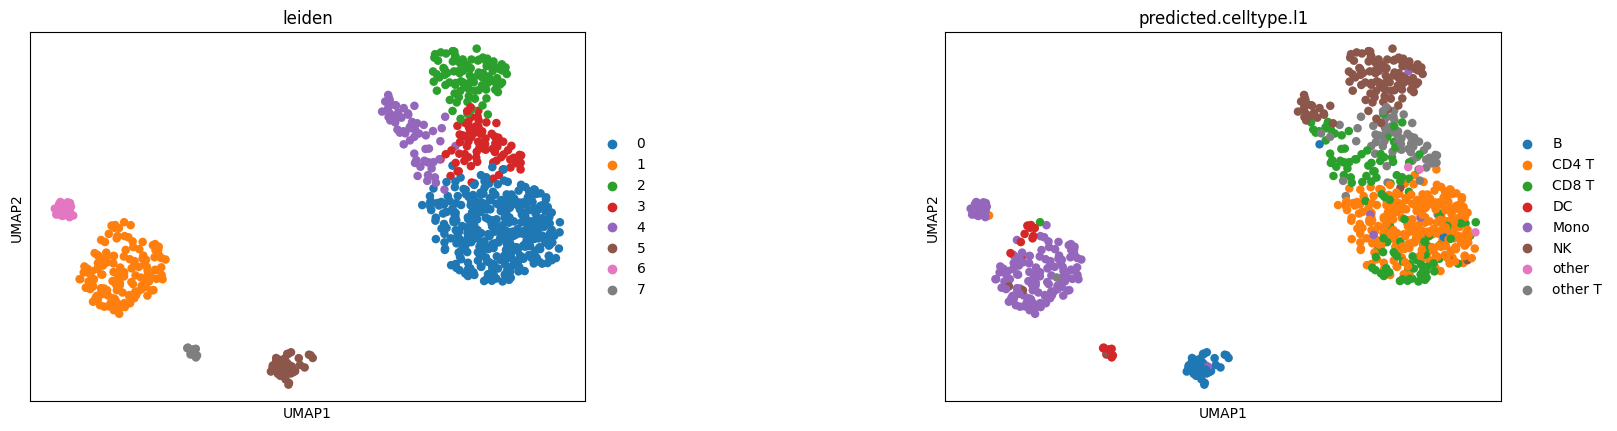

In [12]:
sc.pl.umap(adata, color=['leiden', "predicted.celltype.l1"], wspace=0.5)

## Step 2: Alternative Splicing Analysis

DOLPHIN begins with cell embeddings that cluster cells sharing similar exon and junction patterns. Based on these embeddings, DOLPHIN aggregates reads from neighboring cells to improve signal for downstream splicing analysis.

- For the **cell aggregation** step, please refer to the tutorial [here](../tutorials/step4_cell_aggregation.ipynb).
- For running **alternative splicing detection using Outrigger**, follow the instructions in the tutorial [here](../tutorials/step6_alternative_splicing_analysis.ipynb).


In [2]:
import scanpy as sc

In [4]:
## adata version of psi matrix generated directly from Outrigger
adata_psi = sc.read_h5ad("/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/alternative_splicing/fsla_PSI.h5ad")

### Step 2-1: Number of Splicing Events Detected

In this step, we evaluate the number of splicing events (combined ES and MXE) detected per cell. A splicing event is considered "detected" if it has a valid (non-NaN) PSI value. This gives an overview of the coverage and completeness of splicing information across the dataset.


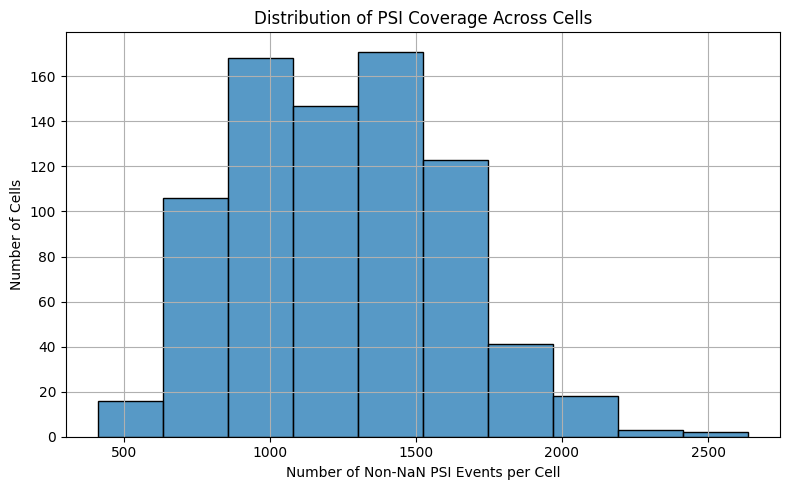

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

psi_df = adata_psi.to_df()

# Count non-NaN PSI values per cell (row-wise)
non_nan_counts = psi_df.notna().sum(axis=1)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(non_nan_counts, bins=10, kde=False)
plt.xlabel("Number of Non-NaN PSI Events per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of PSI Coverage Across Cells")
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 2-2: Cell Clustering Using PSI Values

In this step, we use the adata_psi_random dataset. These PSI values represent alternative splicing patterns and are used to identify clusters of cells with similar splicing profiles.


8


<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

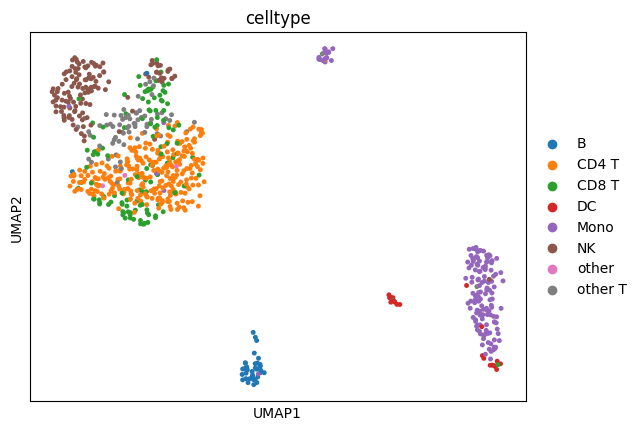

In [18]:
adata_psi_random = sc.read_h5ad("/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/alternative_splicing/fsla_PSI_random.h5ad")
## get cluster
sc.tl.pca(adata_psi_random, svd_solver='arpack')
sc.pp.neighbors(adata_psi_random)
sc.tl.umap(adata_psi_random)
for res in np.arange(0.0,2,0.01):
    sc.tl.leiden(adata_psi_random, res, random_state=0)
    if len(set(adata_psi_random.obs["leiden"])) == len(set(adata_psi_random.obs["celltype1"])):
        break
print(len(set(adata_psi_random.obs["leiden"])))
adata_psi_random.obs["celltype"] = adata_psi_random.obs["celltype1"]
sc.pl.umap(adata_psi_random, color=["celltype"], show=False, s=50)

### Step 2-3: Differential Alternative Splicing

In this step, we use the adata_psi_DAS.h5ad file to perform differential alternative splicing analysis. 


In [19]:
adata_psi_DAS = sc.read_h5ad("/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/alternative_splicing/fsla_PSI_DAS.h5ad")

In [22]:
adata_psi_DAS.var["new_name"] = adata_psi_DAS.var.index
adata_psi_DAS.var["new_name"] = adata_psi_DAS.var["new_name"].astype(str) + '|Gene' + adata_psi_DAS.var["gene_name"].astype(str)
adata_psi_DAS.var["event"] = adata_psi_DAS.var.index
adata_psi_DAS.var = adata_psi_DAS.var.set_index("new_name")
adata_psi_DAS.var.index.name=None

In [26]:
sc.tl.rank_genes_groups(adata_psi_DAS, 'celltype1', method='wilcoxon', key_added="psi_DAS_wilcoxon")

/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 4978 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

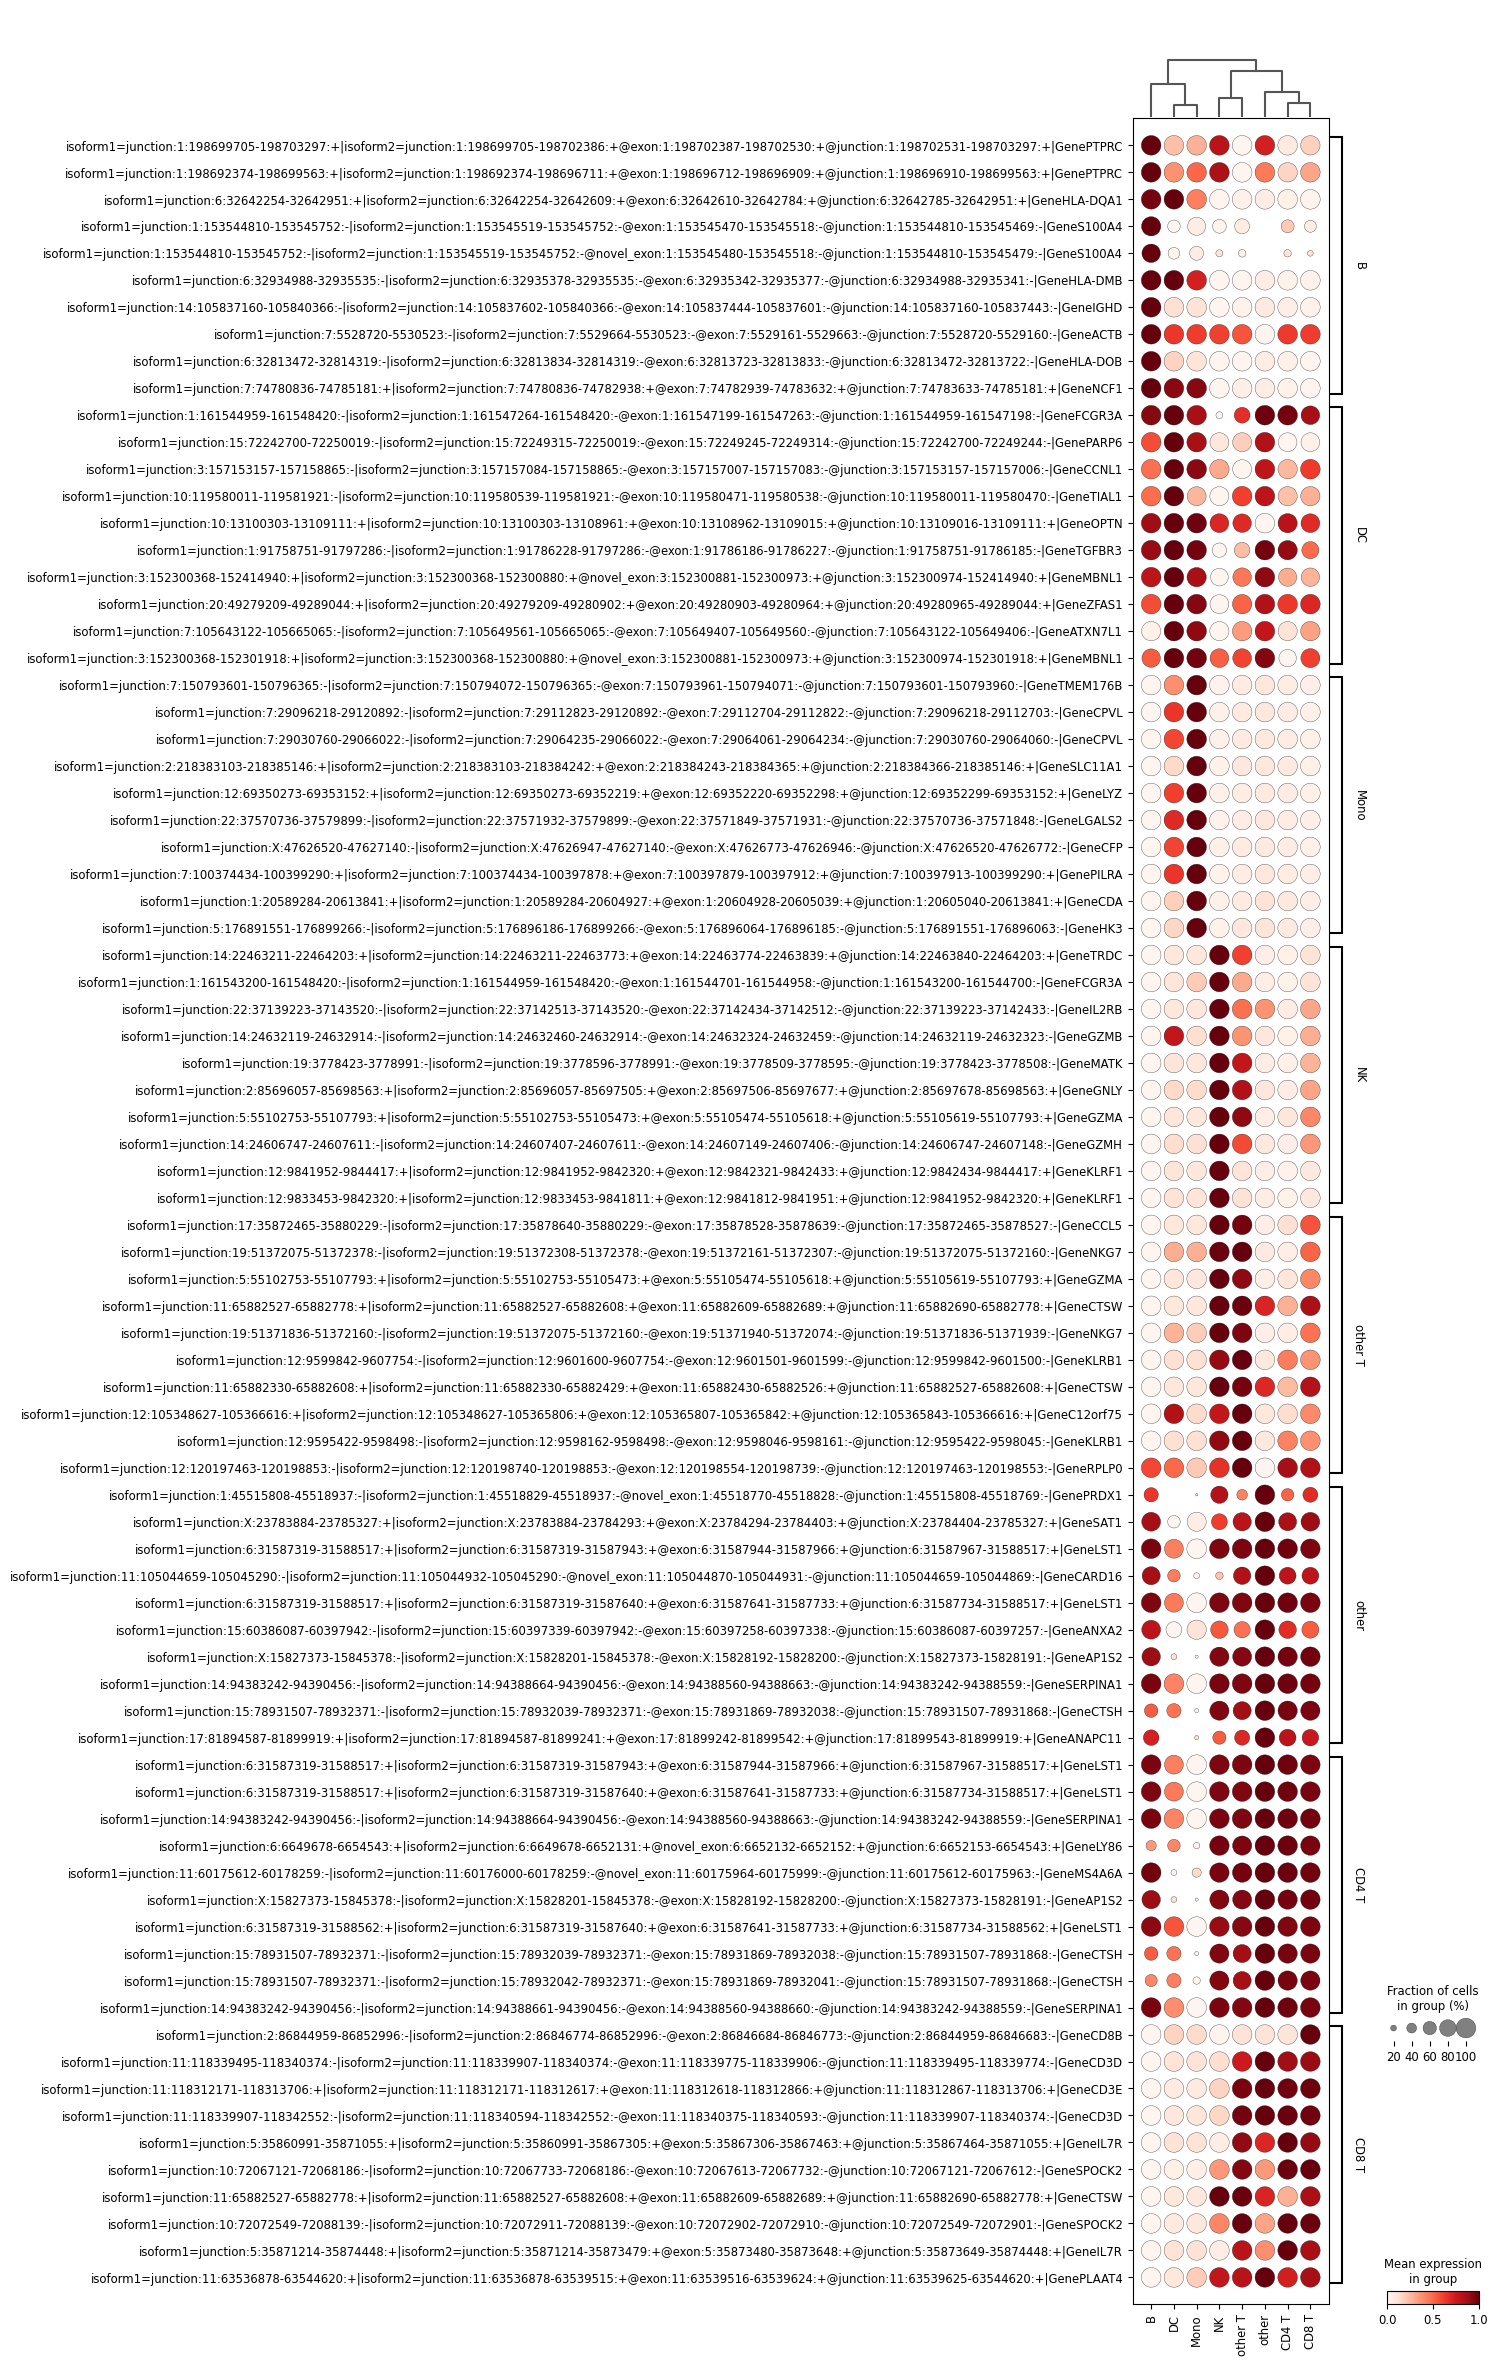

In [27]:
sc.pl.rank_genes_groups_dotplot(adata_psi_DAS, key="psi_DAS_wilcoxon", n_genes=10, standard_scale='var', swap_axes=True, show=False)

### Step 2-4: Alternative Splicing Modality Analysis

In this step, we perform alternative splicing modality analysis using the [anchor](https://github.com/yeolab/anchor/tree/a80d71ad7dda334d197f75a472115403c42f7732) module from the Expedition suite. This tool identifies the distributional modality of splicing events (e.g., bimodal, unimodal) across single cells.

To use this function, please make sure to install the anchor module as instructed in the official tutorial. 


In [26]:
import anchor
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
adata_psi = anndata.read_h5ad("/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/alternative_splicing/fsla_PSI.h5ad")
psi_df = adata_psi.to_df()

In [ ]:
for i, _type in enumerate(list(set(adata_psi.obs["celltype1"]))):
    ## get the list of cell names in each cell type
    print(_type)
    current_sample_list = list(adata_psi.obs[adata_psi.obs["celltype1"] == _type].index)
    data_sub = psi_df.loc[current_sample_list]

    #run anchor
    bm = anchor.BayesianModalities()
    current_modal = bm.fit_predict(data_sub)
    
    df_temp = pd.DataFrame(current_modal, columns=[_type])
    if i == 0:
        df_mod = df_temp
    else:
        df_mod = pd.merge(df_mod, df_temp, left_index=True, right_index=True)

DC
CD4 T
B
CD8 T
other
NK
other T
Mono


In [22]:
df_mod

,DC,CD4T,B,CD8T,other,NK,otherT,Mono
isoform1=junction:10:100246936-100253420:-|isoform2=junction:10:100250333-100253420:-@exon:10:100250248-100250332:-@junction:10:100246936-100250247:-,NaN,uncategorized,NaN,NaN,NaN,NaN,uncategorized,NaN
isoform1=junction:10:100256477-100260965:-|isoform2=junction:10:100260320-100260965:-@exon:10:100260218-100260319:-@junction:10:100256477-100260217:-,NaN,NaN,NaN,uncategorized,NaN,NaN,NaN,NaN
isoform1=junction:10:100489762-100490705:-|isoform2=junction:10:100490323-100490705:-@exon:10:100490008-100490322:-@junction:10:100489762-100490007:-,NaN,uncategorized,NaN,NaN,NaN,NaN,uncategorized,NaN
isoform1=junction:10:100496432-100497666:-|isoform2=junction:10:100497281-100497666:-@exon:10:100497135-100497280:-@junction:10:100496432-100497134:-,NaN,uncategorized,NaN,NaN,NaN,uncategorized,NaN,NaN
isoform1=junction:10:100498208-100499159:-|isoform2=junction:10:100498805-100499159:-@exon:10:100498705-100498804:-@junction:10:100498208-100498704:-,NaN,uncategorized,NaN,NaN,NaN,uncategorized,NaN,NaN
...,...,...,...,...,...,...,...,...
isoform1=junction:X:2723365-2738199:+@exon:X:2738200-2738256:+@junction:X:2738257-2740778:+|isoform2=junction:X:2723365-2726259:+@exon:X:2726260-2726373:+@junction:X:2726374-2740778:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isoform1=junction:X:41342837-41343736:+@exon:X:41343737-41343822:+@junction:X:41343823-41344029:+|isoform2=junction:X:41342837-41343215:+@exon:X:41343216-41343351:+@junction:X:41343352-41344029:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isoform1=junction:X:47657291-47657781:-@exon:X:47657183-47657290:-@junction:X:47652145-47657182:-|isoform2=junction:X:47657640-47657781:-@exon:X:47657572-47657639:-@junction:X:47652145-47657571:-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isoform1=junction:X:47657291-47657781:-@novel_exon:X:47657205-47657290:-@junction:X:47652145-47657204:-|isoform2=junction:X:47657640-47657781:-@exon:X:47657572-47657639:-@junction:X:47652145-47657571:-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#save the modality results
df_mod.to_csv("./modality.csv")

In [23]:
## Plot the modality result
plt_event = psi_df.T.stack().reset_index(name='psi').rename(columns={"level_0":"event_id", "level_1":"cell_name"})
plt_event = pd.merge(plt_event, pd.DataFrame(adata_psi.obs), left_on="cell_name", right_index=True)

In [24]:
event_name = "isoform1=junction:1:198699705-198703297:+|isoform2=junction:1:198699705-198702386:+@exon:1:198702387-198702530:+@junction:1:198702531-198703297:+"
plt_final = plt_event[plt_event["event_id"] == event_name]
plt_final["Modality"] = plt_final["celltype1"]
plt_final['Modality'] = plt_final['Modality'].apply(lambda x: x.replace(' ', ''))
mod_label = df_mod.loc[event_name].to_dict()
plt_final = plt_final.replace({"Modality": mod_label})

/tmp/ipykernel_914322/1683559342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_final["Modality"] = plt_final["celltype1"]
/tmp/ipykernel_914322/1683559342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_final['Modality'] = plt_final['Modality'].apply(lambda x: x.replace(' ', ''))


/tmp/ipykernel_914322/3399849914.py:2: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data = plt_final, x = "celltype1", y = "psi", s=2, linewidth=0, dodge=True, jitter=0.3, hue="Modality", edgecolor= ["#4474C4", "#6FAE45", "#C74546", "#EF7E33", "#FFC101"],palette=["#4474C4", "#6FAE45", "#C74546", "#EF7E33", "#FFC101"]).set_title("PTPRC:HsaEX0051104")


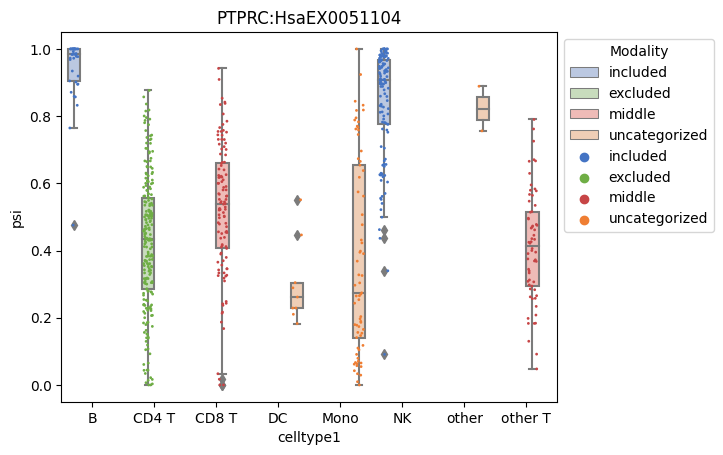

In [27]:
ax = sns.boxplot(plt_final, x="celltype1", y="psi", hue="Modality", palette=["#B5C6E7", "#C6E1B8", "#F9B3AD", "#F8CDAD", "#E42320"])
sns.stripplot(data = plt_final, x = "celltype1", y = "psi", s=2, linewidth=0, dodge=True, jitter=0.3, hue="Modality", edgecolor= ["#4474C4", "#6FAE45", "#C74546", "#EF7E33", "#FFC101"],palette=["#4474C4", "#6FAE45", "#C74546", "#EF7E33", "#FFC101"]).set_title("PTPRC:HsaEX0051104")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In this step, we use splicing modality patterns to cluster cells. Each splicing event's modality (e.g., included, excluded, bimodal, etc.) is converted into a one-hot encoded format. This binary representation allows us to use standard clustering techniques to group cells based on shared splicing modalities.

In [1]:
from DOLPHIN.AS.convert_modality_ohe import run_modality_ohe

In [2]:
adata_psi_modality_ohe = run_modality_ohe(
    anchor_output = "/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/modality.csv",
    adata_psi = "/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/fsla_PSI.h5ad",
    cluster_name = "celltype1",
    out_directory = "/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/fsla_PSI_modality_ohe.h5ad"
)

/mnt/data/kailu9/DOLPHIN/DOLPHIN/AS/convert_modality_ohe.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod_num = df_mod.replace(dict_mod_num)


DC
CD4 T
B
CD8 T
other
NK
other T
Mono


In [4]:
adata_psi_modality_ohe

AnnData object with n_obs × n_vars = 795 × 9487
    obs: 'celltype1', 'celltype2'

In [7]:
import scanpy as sc
import numpy as np
sc.tl.pca(adata_psi_modality_ohe, svd_solver='arpack')
sc.pp.neighbors(adata_psi_modality_ohe, n_neighbors=20, n_pcs=40)
sc.tl.umap(adata_psi_modality_ohe, min_dist=0.2,spread=1.5)
for res in np.arange(0.0,2,0.1):
    sc.tl.leiden(adata_psi_modality_ohe, res, random_state=0)
    if len(set(adata_psi_modality_ohe.obs["leiden"])) == len(set(adata_psi_modality_ohe.obs["celltype1"])):
        break

/tmp/ipykernel_951566/818419519.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_psi_modality_ohe, res, random_state=0)


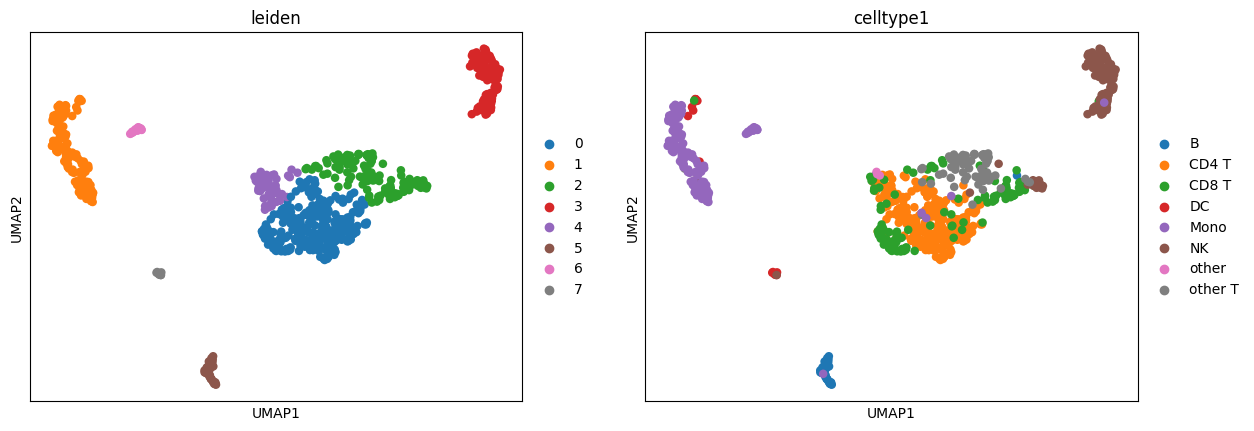

In [9]:
sc.pl.umap(adata_psi_modality_ohe, color=['leiden','celltype1'])